In [1]:
import requests
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
url = "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt"
response = requests.get(url)
open("text_data.txt", "w").write(response.text)

with open("text_data.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
# Downloading stopwords and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'[^a-z0-9\.]', ' ', text)
    #text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text into sentences and words
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]
    
    # Convert to lowercase and remove stopwords
    filtered_words = []
    for sentence in words:
        for word in sentence:
            word = word.lower()
            if word not in stop_words:
                filtered_words.append(word)
    
    # Lemmatize words
    lemmatized_words = []
    for word in filtered_words:
        lemma_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemma_word)
    
    # Join lemmatized words back into sentences
    preprocessed_text = ' '.join(lemmatized_words)
    return preprocessed_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
preprocessed_text = preprocess_text(text)

In [5]:
sentences = preprocessed_text.split(".") # split into sentences
list_of_sentences = []
for sentence in sentences:
    words = sentence.split() # split sentence into words
    list_of_sentences.append(words) # add words to list_of_lists


In [6]:
class Skipgram:
    def __init__(self, corpus, window_size, embedding_size, negative_samples):
        self.corpus = corpus
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.negative_samples = negative_samples
        
        self.word2id = {}
        self.id2word = {}
        self.vocab_size = 0
        self.training_data = []
        self.freq_dist = defaultdict(int)
        self.neg_dist = None
        
        self.w = None
        self.c = None
        self.theta = None
        
    def build_vocab(self):
        for sentence in self.corpus:
            for word in sentence:
                self.freq_dist[word] += 1
        
        sorted_vocab = sorted(self.freq_dist.items(), key=lambda x: x[1], reverse=True)
        for i, (word, freq) in enumerate(sorted_vocab):
            self.word2id[word] = i
            self.id2word[i] = word
            self.vocab_size += 1
            
    def generate_training_data(self):
        for sentence in self.corpus:
            sentence_length = len(sentence)
            for i, word in enumerate(sentence):
                w_target = self.word2id[word]
                
                context_words = sentence[max(0, i - self.window_size) : i] + \
                                sentence[i + 1 : min(sentence_length, i + self.window_size + 1)]
                
                for context_word in context_words:
                    c_target = self.word2id[context_word]
                    negative_samples = self.generate_negative_samples(w_target, c_target)
                    self.training_data.append((w_target, c_target, negative_samples))
        
    def generate_negative_samples(self, w_target, c_target):
        negative_samples = []
        while len(negative_samples) < self.negative_samples:
            sample = random.randint(0, self.vocab_size - 1)
            if sample != w_target and sample != c_target:
                negative_samples.append(sample)
        return negative_samples
    
    def initialize_weights(self):
        self.w = np.random.uniform(-0.5 / self.embedding_size, 0.5 / self.embedding_size,
                                   (self.vocab_size, self.embedding_size))
        self.c = np.random.uniform(-0.5 / self.embedding_size, 0.5 / self.embedding_size,
                                   (self.vocab_size, self.embedding_size))
        self.theta = np.zeros(self.vocab_size)
        
    def train(self, epochs, learning_rate):
        for epoch in range(epochs):
            loss = 0
            for w_target, c_target, negative_samples in self.training_data:
                u = self.w[w_target]
                v = self.c[c_target]
                negative_vectors = self.c[negative_samples]
                
                # positive sample loss
                pos_loss = -np.log(self.sigmoid(np.dot(u, v.T)))
                
                # negative sample loss
                neg_loss = -np.sum(np.log(self.sigmoid(-np.dot(u, negative_vectors.T))))
                
                # total loss
                total_loss = pos_loss + neg_loss
                
                # update weights
                grad_w_target = (self.sigmoid(np.dot(u, v.T)) - 1) * v + \
                                np.sum((1 - self.sigmoid(-np.dot(u, negative_vectors.T)))[:, None] * negative_vectors, axis=0)
                grad_c_target = (self.sigmoid(np.dot(u, v.T)) - 1) * u
                grad_neg_samples = np.outer(1 - self.sigmoid(-np.dot(u, negative_vectors.T)), u)
            
                self.w[w_target] -= learning_rate * grad_w_target
                self.c[c_target] -= learning_rate * grad_c_target
            
                for negative_sample in negative_samples:
                    self.c[negative_sample] -= learning_rate * np.sum(grad_neg_samples, axis=0)
                
                loss += total_loss
            
            print(f"Epoch {epoch+1}: loss = {loss}")
            
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def get_word_vector(self, word):
        word_id = self.word2id[word]
        return self.w[word_id] + self.c[word_id]

    def get_feature_vectors(self):
        feature_vectors = []
        for i in range(self.vocab_size):
            feature_vectors.append(self.w[i] + self.c[i])
        return feature_vectors



In [7]:
skipgram = Skipgram(list_of_sentences, window_size=2, embedding_size=100, negative_samples=4)
skipgram.build_vocab()
skipgram.generate_training_data()

In [12]:
skipgram.initialize_weights()
skipgram.train(epochs=15, learning_rate=0.03)

Epoch 1: loss = 2717726.495797808
Epoch 2: loss = 2049367.7321156783
Epoch 3: loss = 2013169.1122901235
Epoch 4: loss = 1981664.1483934363
Epoch 5: loss = 1933821.5178673905
Epoch 6: loss = 1867810.3019463788
Epoch 7: loss = 1788550.2692564297
Epoch 8: loss = 1702618.4372434898
Epoch 9: loss = 1616413.5314035558
Epoch 10: loss = 1535088.1909846617
Epoch 11: loss = 1461791.3788352886
Epoch 12: loss = 1398403.4745044105
Epoch 13: loss = 1346563.0733049056
Epoch 14: loss = 1307371.085652251
Epoch 15: loss = 1280784.6673897197


In [13]:
words = ['king', 'man', 'queen', 'woman', 'brother', 'sister', 'uncle', 'aunt']
vectors = []
for word in words:
  rep = skipgram.get_word_vector(word)
  vectors.append(rep)

In [28]:
# Apply PCA to reduce the dimensionality of X to 2 dimensions
pca = PCA(n_components=2)
X_2d = pca.fit_transform(vectors)

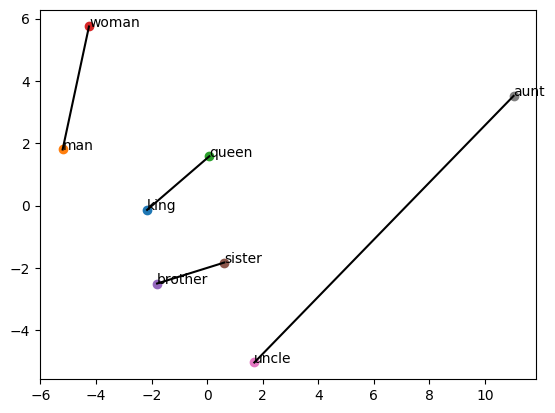

In [31]:
# Define the points
points = dict(zip(words, X_2d))


# Create the plot
fig, ax = plt.subplots()

# Add the points and their labels to the plot
for label, point in points.items():
    ax.scatter(point[0], point[1])
    ax.annotate(label, xy=point)

# Connect the edges
ax.plot([points['king'][0], points['queen'][0]], [points['king'][1], points['queen'][1]], color='black')
ax.plot([points['man'][0], points['woman'][0]], [points['man'][1], points['woman'][1]], color='black')
ax.plot([points['brother'][0], points['sister'][0]], [points['brother'][1], points['sister'][1]], color='black')
ax.plot([points['uncle'][0], points['aunt'][0]], [points['uncle'][1], points['aunt'][1]], color='black')

# Show the plot
plt.show()
